In [29]:

# Default locations if parameter not passed
benchmark_data_path = "tb-compare.pkl"


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
import re
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [31]:
bench_names = df["name"].unique()
print(f"Benchmarks found: {bench_names}")
run_metadata = benchmark_data["config"].applications
n_runs = benchmark_data["config"].metadata.runs

df_bench = df[df["name"] == 'tb-compare']


n_runs = benchmark_data["config"].metadata.runs
print(f"Number of runs: {n_runs}")
print(df_bench.columns)
print(df_bench.head())


Benchmarks found: ['tb-compare']
Number of runs: 2
Index(['name', 'full_output', 'tb_path', 'hosts', 'ompc_tb_iter_num', 'image',
       'type', 'iter', 'node_count', 'time'],
      dtype='object')
         name                                        full_output  \
0  tb-compare  [1749753550.674741] [sorgan-cpu1:417424:0]    ...   
1  tb-compare  [1749753551.241728] [sorgan-cpu1:417539:0]    ...   
2  tb-compare  [1749753551.785171] [sorgan-cpu1:417655:0]    ...   
3  tb-compare  [1749753552.351078] [sorgan-cpu1:417775:0]    ...   
4  tb-compare  [1749753552.903408] [sorgan-cpu1:417890:0]    ...   

        tb_path                                            hosts  \
0  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
1  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
2  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
3  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
4  tb-main-loop  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,

In [32]:
# print the field full_output of the first row
print("Full output of the first row:")

# tb_time field (seconds)
# get total time from the output
def extract_elapsed_time(text):
    matches = re.findall(r"Elapsed Time ([\d.eE+-]+) seconds", text)
    if matches:
        # gets last mach
        # float() already handles scientific notation
        return float(matches[-1])
    return float('nan')

def extract_total_sched_time(text):
    # Find all "Scheduling : <number>"
    matches = re.findall(r"Scheduling\s*:\s*(\d+)", text)
    if not matches:
        return None
    total_microseconds = sum(int(m) for m in matches)
    return total_microseconds / 1e6  # microseconds to seconds

df_bench['tb_time'] = df_bench['full_output'].apply(extract_elapsed_time)
df_bench['sched_time'] = df_bench['full_output'].apply(extract_total_sched_time)

print(df_bench.columns)



Full output of the first row:
Index(['name', 'full_output', 'tb_path', 'hosts', 'ompc_tb_iter_num', 'image',
       'type', 'iter', 'node_count', 'time', 'tb_time', 'sched_time'],
      dtype='object')


In [33]:
import numpy as np
import pandas as pd

# 1) Bootstrap helpers
def bootstrap_lower(x, n_boot=1000, ci=95):
    boots = np.random.choice(x, (n_boot, len(x)), replace=True).mean(axis=1)
    return np.percentile(boots, (100 - ci) / 2)

def bootstrap_upper(x, n_boot=1000, ci=95):
    boots = np.random.choice(x, (n_boot, len(x)), replace=True).mean(axis=1)
    return np.percentile(boots, 100 - (100 - ci) / 2)

# 2) Your grouping keys
group_fields = [
    'name', 'node_count', 'iter',
    'ompc_tb_iter_num', 'image', 'type', 'tb_path'
]

# 3) Named aggregation—no level_7, straight to mean/CI columns
df_summary = (
    df_bench
    .groupby(group_fields)
    .agg(
        tb_time_mean     = ('tb_time',    'mean'),
        tb_time_ci_lower = ('tb_time',    bootstrap_lower),
        tb_time_ci_upper = ('tb_time',    bootstrap_upper),

        sched_time_mean     = ('sched_time',    'mean'),
        sched_time_ci_lower = ('sched_time',    bootstrap_lower),
        sched_time_ci_upper = ('sched_time',    bootstrap_upper),
    )
    .reset_index()
)

print(df_summary.columns.tolist())


['name', 'node_count', 'iter', 'ompc_tb_iter_num', 'image', 'type', 'tb_path', 'tb_time_mean', 'tb_time_ci_lower', 'tb_time_ci_upper', 'sched_time_mean', 'sched_time_ci_lower', 'sched_time_ci_upper']


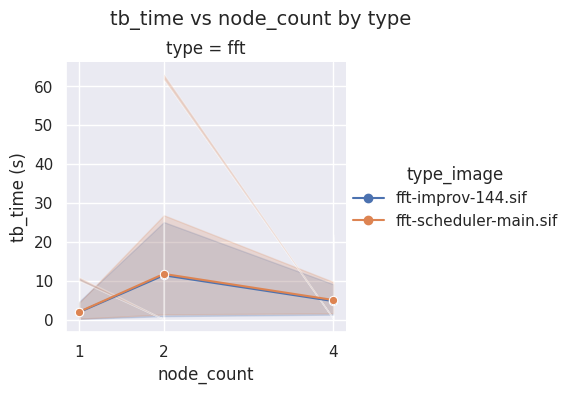

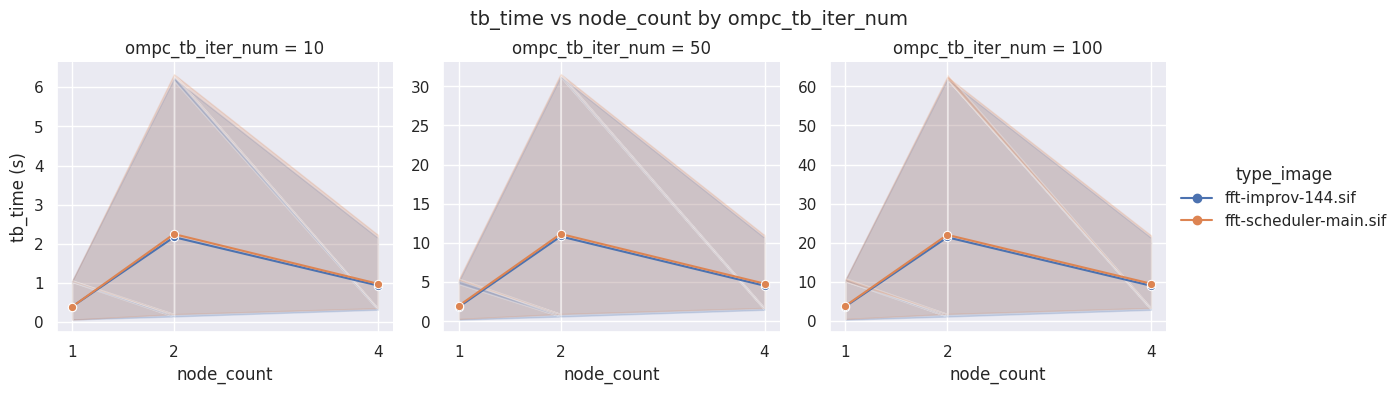

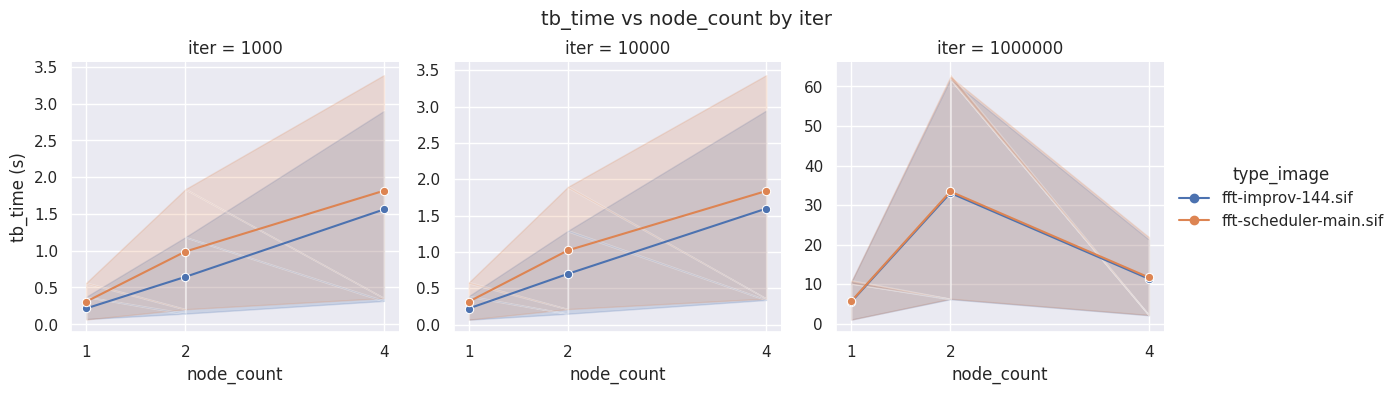

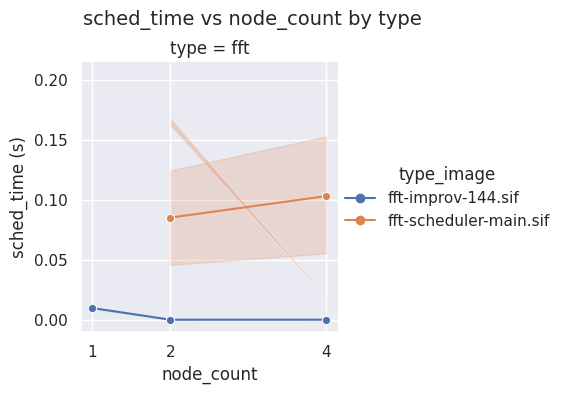

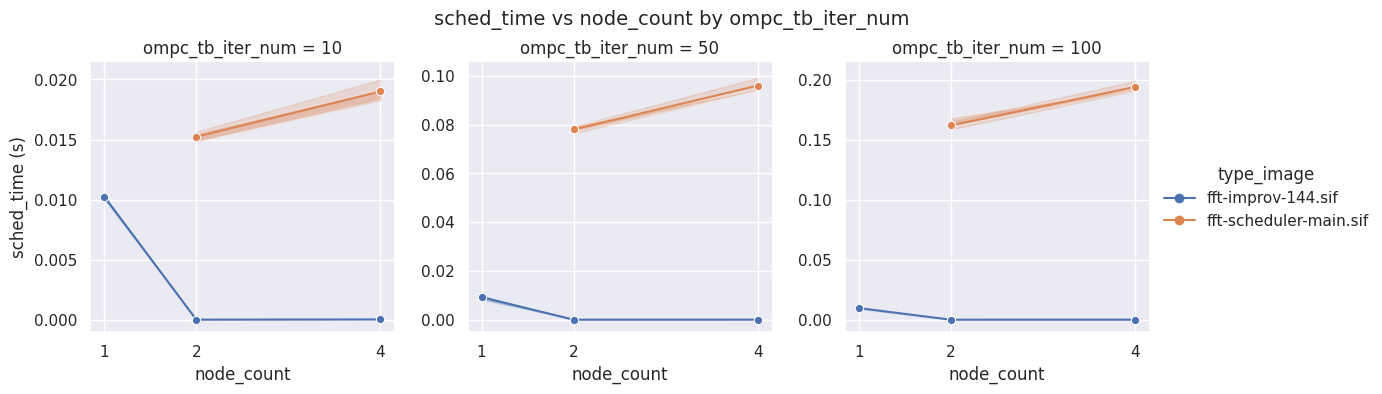

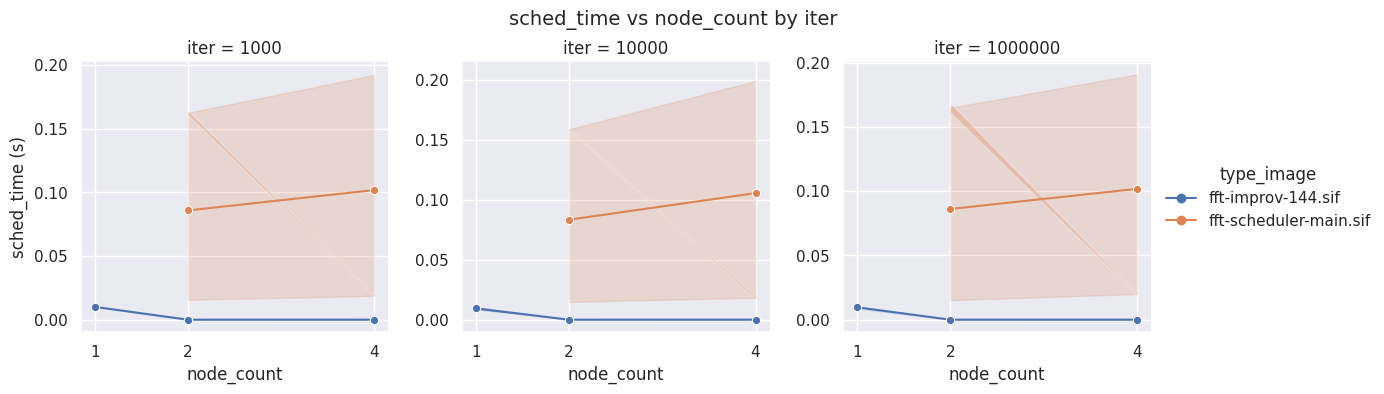

In [34]:
df_summary['type_image'] = df_summary['type'] + '-' + df_summary['image']

metrics = ['tb_time', 'sched_time']
facet_vars = ['type', 'ompc_tb_iter_num', 'iter']

for metric in metrics:
    for facet in facet_vars:
        g = sns.relplot(
            data=df_summary,
            x='node_count',
            y=f'{metric}_mean',
            kind='line',
            hue='type_image',
            col=facet,
            marker='o',
            facet_kws={'sharey': False},
            legend='full',
            height=4,
            aspect=1
        )

        # Overlay CI ribbons
        for ax, facet_val in zip(g.axes.flat, g.col_names):
            sub = df_summary[df_summary[facet] == facet_val]
            for label_val in sub['type_image'].unique():
                sub2 = sub[sub['type_image'] == label_val]
                ax.fill_between(
                    sub2['node_count'],
                    sub2[f'{metric}_ci_lower'],
                    sub2[f'{metric}_ci_upper'],
                    alpha=0.3
                )
        ax.set_xticks(sorted(sub2['node_count'].unique()))
        g.set_axis_labels('node_count', f'{metric} (s)')
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(f'{metric} vs node_count by {facet}', fontsize=14)
        plt.show()


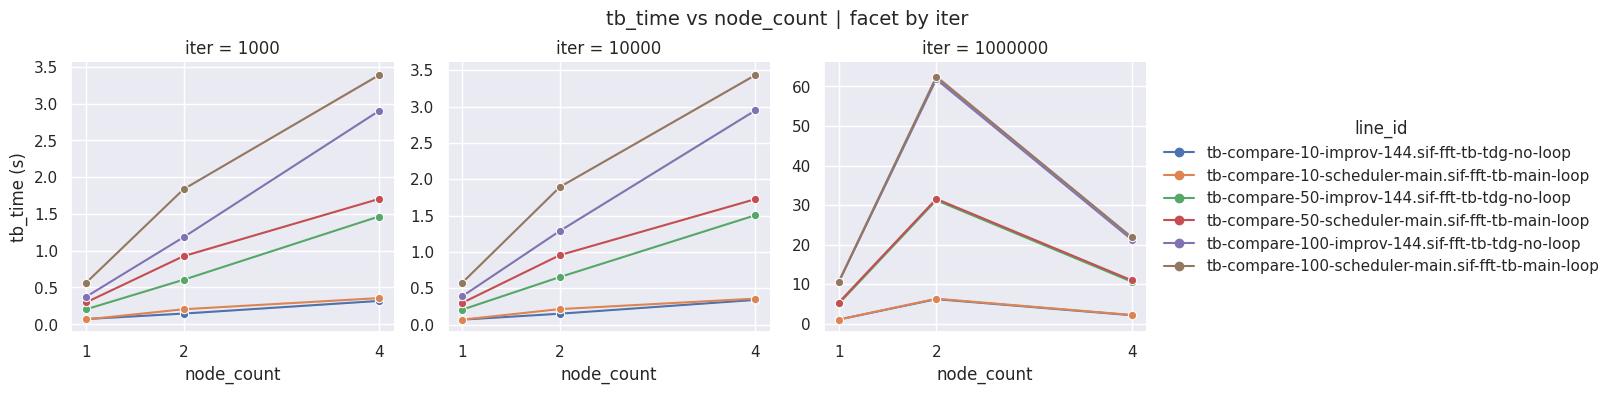

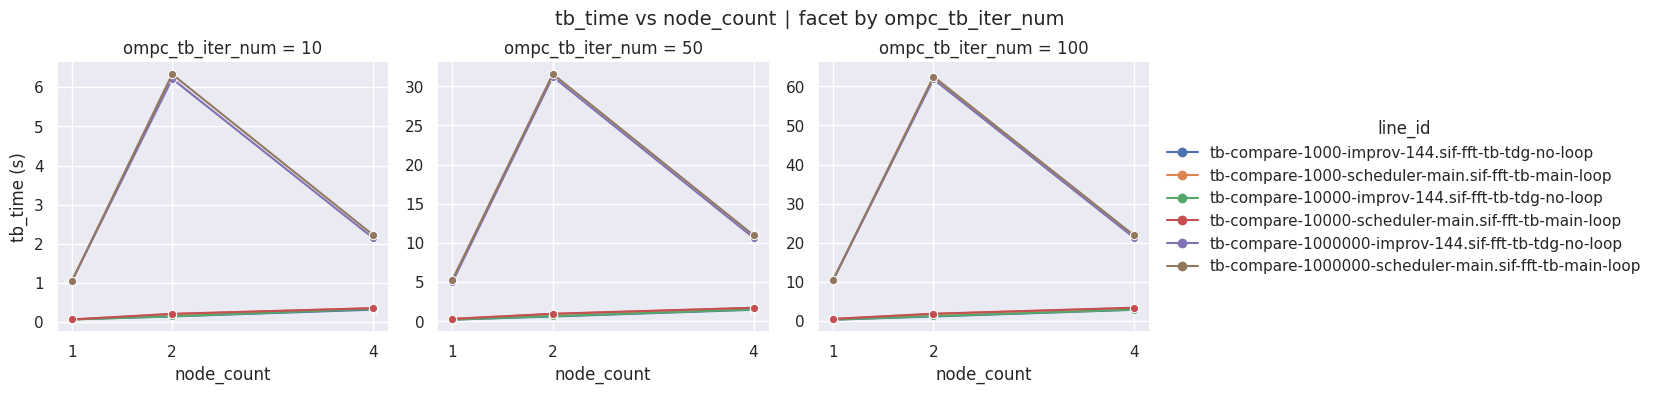

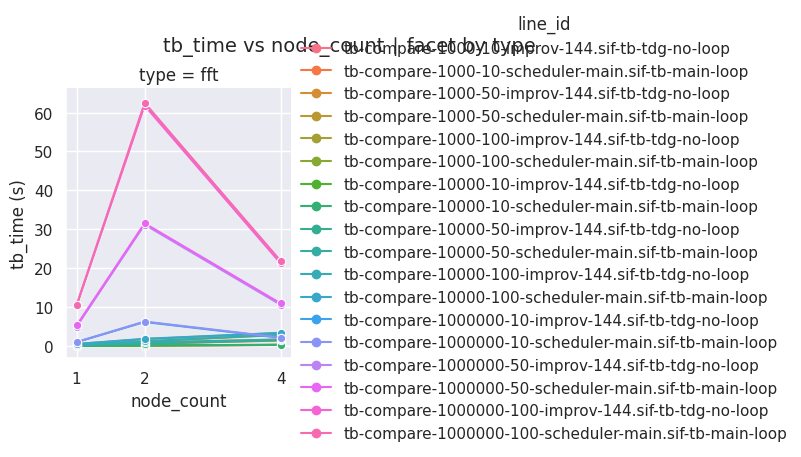

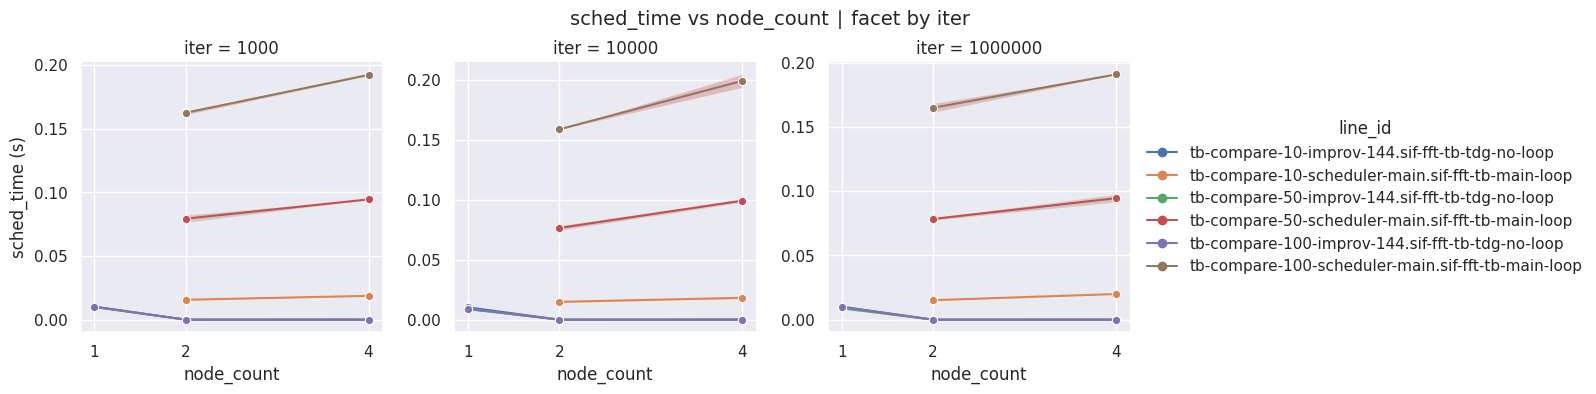

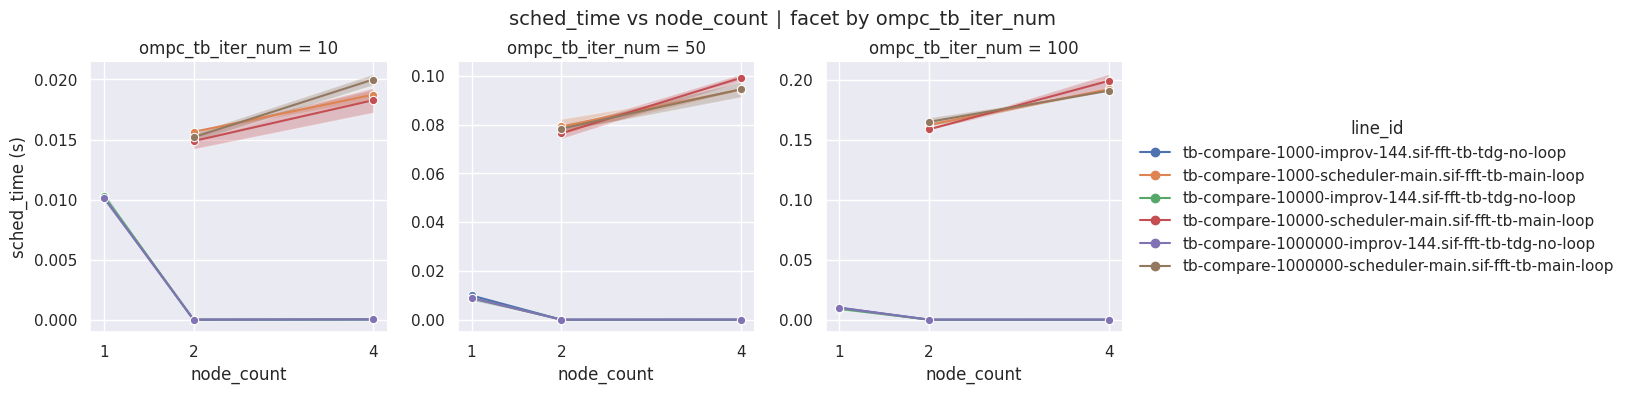

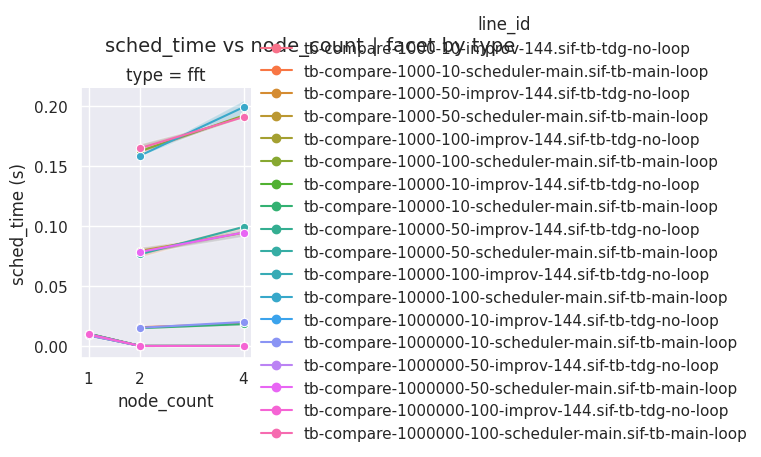

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics    = ['tb_time', 'sched_time']
facet_vars = ['iter', 'ompc_tb_iter_num', 'type']   # the three ways you want one grid per value
group_fields = ['name','node_count','iter','ompc_tb_iter_num','image','type','tb_path']

for metric in metrics:
    for facet in facet_vars:
        # 1) build a line‐ID from all group keys except 'node_count' and this facet
        line_cols = [c for c in group_fields if c not in (facet,'node_count')]
        df_summary['line_id'] = (
            df_summary[line_cols]
              .astype(str)
              .agg('-'.join, axis=1)
        )

        # 2) draw
        g = sns.relplot(
            data = df_summary,
            x    = 'node_count',
            y    = f'{metric}_mean',
            kind = 'line',
            hue  = 'line_id',
            col  = facet,
            marker = 'o',
            facet_kws = {'sharey': False},
            height    = 4,
            aspect    = 1,
            legend    = 'full'
        )

        # 3) add the custom CI ribbon & restrict ticks
        for ax, val in zip(g.axes.flat, g.col_names):
            sub = df_summary[df_summary[facet] == val]
            ax.set_xticks(sorted(sub['node_count'].unique()))
            for lid, sub2 in sub.groupby('line_id'):
                ax.fill_between(
                    sub2['node_count'],
                    sub2[f'{metric}_ci_lower'],
                    sub2[f'{metric}_ci_upper'],
                    alpha=0.3
                )

        # 4) polish
        g.set_axis_labels('node_count', f'{metric} (s)')
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(f"{metric} vs node_count ∣ facet by {facet}", fontsize=14)
        plt.show()
